In [ ]:
import json
import pandas
import time
import os
import recordlinkage
import jellyfish as jf
import csv

In [ ]:
outputDir = '..//scrapedData//'
field_agg = "_"

## Load the source file dict
sourceFiles = json.loads(open('..//config//sourceFiles.json', "r").read())

## Load the file schema
sourceSchema = json.loads(open('..//config//sourceSchema.json', "r").read())

## Load the id config
idConfig = json.loads(open('..//config//idConfig.json', "r").read())

In [ ]:
## If there are multiple files for any given dataset, then this function will combine all of those
## records into a single dict
def mergeSourceFiles (source, outputDir, sourceFiles):
    recordList = []
    for file in sourceFiles[source]:  
        file = json.loads(open(outputDir + file, "r", encoding="utf-8").read())
        for record in file:
            recordList.append(record)
    return recordList

In [ ]:
## Cycle through all of files per source and drop into a list of dicts
## Printing list names for reference sake
dfs = []
for key in sourceFiles.keys():
    vars()[key] = mergeSourceFiles (key, outputDir, sourceFiles)
    dfs.append(vars()[key])

In [ ]:
## Clean up dirty names
def mungeID(playerString):
    if (playerString is not None):
        return ''.join(e for e in playerString if e.isalnum()).lower().replace("jr.", "").replace("st.", "state") 
    else:
        return 'ERROR!ERROR!ERROR!ERROR'

In [ ]:
#create a universal identifier
#CHANGE - this is not going to be a list
#CFB-Ref reports it in chronological order so we will join based on position 1

def createNewID (fieldList, thisDict, fieldAgg):
    finalID= ''
    for i in thisDict:
        for idx, val in enumerate(fieldList):
            if (type(i[val]) is list):
                i[val]= mungeID(i[val][0])
                if (len(fieldList) -1 == idx):
                    finalID += str(i[val]).strip('[]').strip("''")
            elif (type(val) is not list):
                i[val] = mungeID(i[val])
                if (len(fieldList) - 1 == idx):
                    finalID += i[val]
                else:
                    finalID = i[val] + fieldAgg
        i['ID'] = finalID
        finalID=''

In [ ]:
createNewID(idConfig['sports247'], sports247, field_agg)
createNewID(idConfig['rivals'], rivals, field_agg)
createNewID(idConfig['cfbRef'], cfbRef, field_agg)
createNewID(idConfig['allConf'], allConf, field_agg)
createNewID(idConfig['allAmerican'], allAmerican, field_agg)
createNewID(idConfig['nflData'], nflData, field_agg)
createNewID(idConfig['ncaa'], ncaa, field_agg)

In [ ]:
df_sports247 = pandas.DataFrame(sports247)
df_rivals = pandas.DataFrame(rivals)
df_cfbRef = pandas.DataFrame(cfbRef)
df_allConf = pandas.DataFrame(allConf)
df_allAmerican = pandas.DataFrame(allAmerican)
df_nflData = pandas.DataFrame(nflData)
df_ncaa = pandas.DataFrame(ncaa)

In [ ]:
df_sports247.index.name = '247_index'
df_rivals.index.name = 'rivals_index'
indexer = recordlinkage.Index()
indexer.block('school')
indexer.block('year')
candidate_links = indexer.index(df_sports247, df_rivals)

In [ ]:
c = recordlinkage.Compare()

c.exact('ID', 'ID', label='ID')

c.string('playerName', 'playerName', method='damerau_levenshtein', label='playerName')
c.string('school', 'school', label='college')
c.string('city', 'city', label='city')
c.exact('state', 'state', label='state')
c.string('highSchool', 'highSchool', label='highSchool')
c.exact('position', 'position', label='position')
c.exact('year', 'year', label='year')

# The comparison vectors
features = c.compute(candidate_links, df_sports247, df_rivals)

features

ID  playerName  college      city  state  highSchool  \
247_index rivals_index                                                         
0         19             0    0.222222      0.0  0.100000      0    0.208333   
          34             0    0.000000      1.0  0.083333      0    0.083333   
          43             0    0.083333      1.0  1.000000      1    1.000000   
          51             0    0.250000      1.0  0.166667      0    0.090909   
          55             0    0.250000      1.0  0.333333      0    0.105263   
...                     ..         ...      ...       ...    ...         ...   
22976     22794          0    0.083333      1.0  1.000000      1    0.136364   
          22797          0    0.272727      0.0  0.000000      0    0.227273   
          22801          0    0.153846      1.0  0.222222      0    0.090909   
          22803          0    0.181818      1.0  0.111111      0    0.181818   
          22808          0    0.272727      0.2  0.100000      0    0.045455   

                        position  year  
247_index rivals_index                  
0         19                   0     1  
          34                   0     0  
          43                   0     0  
          51                   0     0  
          55                   0     0  
...                          ...   ...  
22976     22794                0     0  
          22797                0     1  
          22801                0     0  
          22803                0     0  
          22808                0     1  

[36998834 rows x 8 columns]

In [ ]:
features['sum'] = (features['playerName'] + features['college'] + features['city'] + features['state'] + features['highSchool'] + features['year'] + features['position'])
features.describe()

,ID,playerName,college,city,state,highSchool,position,year,sum
count,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07,3.699883e+07
mean,5.726126e-04,1.534649e-01,3.788246e-01,1.340277e-01,1.045372e-01,1.263037e-01,2.979456e-02,7.458801e-01,1.672833e+00
std,2.392247e-02,9.615825e-02,3.907788e-01,1.202838e-01,3.059561e-01,9.880092e-02,1.700201e-01,4.353653e-01,4.466541e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,0.000000e+00,8.333333e-02,1.000000e-01,7.142857e-02,0.000000e+00,6.666667e-02,0.000000e+00,0.000000e+00,1.398291e+00
50%,0.000000e+00,1.538462e-01,1.666667e-01,1.111111e-01,0.000000e+00,1.176471e-01,0.000000e+00,1.000000e+00,1.548413e+00
75%,0.000000e+00,2.142857e-01,1.000000e+00,1.875000e-01,0.000000e+00,1.764706e-01,0.000000e+00,1.000000e+00,1.764103e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00


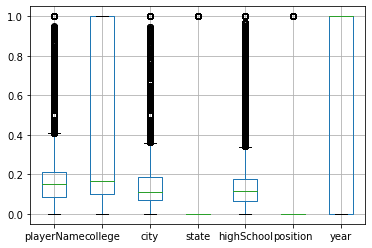

In [ ]:
features.boxplot(column=['playerName', 'college', 'city', 'state', 'highSchool', 'position', 'year'])

In [ ]:
not_id = features[features['ID'] != 1]
not_id = (not_id.loc[not_id['sum'] > 6.62])

#all_matches = ((features.loc[features['sum'] > 6.62] & features.loc[features['ID'] == 0]) | (features.loc[features['ID'] == 1]))

In [ ]:
not_id.reset_index(inplace=True)

In [ ]:
noIDDict = not_id.to_dict('records')

In [ ]:
## Hey Sober Andrew - this is where things break
## You are trying to iterate through keys so you don't have to manually
## Set each of the variables in the new dictionary.

finalSet = []
#print(df_sports247.to_dict('records'))
for record in noIDDict:
    finalRecord = {}
    for key,value in sports247.to_dict('records'):
        if (df_sports247.Index == record['247_index']):
            print ('SUCCESS MOTHERFUCKER')

AttributeError: 'list' object has no attribute 'to_dict'

In [ ]:
#df_sports247.head()
df_sports247.iloc[5618, :]

school                                   minnesota
year                                          2017
playerName                            jacobpaulson
highSchool         Christian Academy Of Louisville
city                                    Louisville
state                                           KY
position                                        TE
height                                          77
weight                                         245
compRating                                  0.8471
compStars                                        3
nationalRank                                   921
positionRank                                    42
stateRank                                        3
247Rating                                      NaN
247Stars                                       NaN
247positionRank                                NaN
247stateRank                                   NaN
ID                          jacobpaulson_minnesota
247nationalRank                

In [ ]:
test = df_rivals.iloc[2673, :]
test['year']

'2017'

In [ ]:
features.iloc[2673, :]

ID            0.000000
playerName    0.187500
college       1.000000
city          0.166667
state         0.000000
highSchool    0.000000
position      0.000000
year          0.000000
sum           1.354167
Name: (2, 837), dtype: float64

In [ ]:
print(fuzzy_matches)

{'ID': {(5618, 2673): 0, (5627, 2285): 0, (16265, 11918): 0, (20929, 20585): 0, (8354, 6189): 0, (2749, 5638): 0, (18261, 22161): 0, (16794, 15067): 0, (20478, 18000): 0, (12471, 14935): 0, (14638, 15928): 0, (22446, 22447): 0, (13764, 12531): 0, (18196, 18098): 0, (11379, 14881): 0, (12689, 13543): 0, (4780, 2528): 0, (8808, 6789): 0, (134, 594): 0, (138, 186): 0, (15568, 14344): 0, (6512, 6751): 0, (12738, 13961): 0, (18347, 20467): 0, (22550, 19244): 0, (21258, 20926): 0, (12355, 15055): 0, (6371, 8578): 0, (19886, 17108): 0, (17553, 19929): 0, (5244, 3921): 0, (20062, 22795): 0, (21231, 22730): 0, (22063, 20457): 0, (21356, 17817): 0, (22759, 17240): 0, (14547, 11375): 0, (1668, 2768): 0, (13142, 14452): 0, (3681, 2437): 0, (4747, 4040): 0, (411, 2164): 0, (3498, 2903): 0, (14274, 14354): 0, (6399, 8874): 0, (15233, 10404): 0, (7673, 8222): 0, (18361, 20734): 0, (20670, 17772): 0, (16001, 14446): 0, (18655, 18397): 0, (5674, 4864): 0, (19791, 21843): 0, (3690, 257): 0, (13439, 1475

In [ ]:
ids_to_match = []
ids = fuzzy_matches['ID']
for key in ids.keys():
    i = {}
    print(key[0])
    i['247'] = key[0]
    i['rivals'] = key[1]
    ids_to_match.append(i)


5618
5627
16265
20929
8354
2749
18261
16794
20478
12471
14638
22446
13764
18196
11379
12689
4780
8808
134
138
15568
6512
12738
18347
22550
21258
12355
6371
19886
17553
5244
20062
21231
22063
21356
22759
14547
1668
13142
3681
4747
411
3498
14274
6399
15233
7673
18361
20670
16001
18655
5674
19791
3690
13439
9507
8625
6238
553
18111
14418
1353
20429
5719
6042
12455
19729
21758
312
15595
17172
20766
5101
17262
14236
3688
13300
9850
11378
6185
15986
9360
13786
16239
20950
12361
19849
18081
16503
10802
16037
10296
5850
11404
6613
18664
10327
19384
2422
12188
22503
21352
18193
718
20569
22508
150
14545
8542
3143
1198
9482
4049
15242
12163
14256
3310
9684
21649
21048
11765
19313
4527
19066
1820
5476
21489
19059
18923
14285


In [ ]:
fuzzy_list = []
for i in ids_to_match:
    sports247_dict = pandas.DataFrame(df_sports247.iloc[i['247'], :]).to_dict()
    
    rivals_dict= pandas.DataFrame(df_rivals.iloc[i['rivals'], :]).to_dict()
    for i in rivals_dict:   
        sports247_dict.update(i)
    fuzzy_list.append(sport247_dict)

TypeError: 'int' object is not iterable

In [ ]:
print(fuzzy_list)

[{14285: {'school': 'missouri', 'year': '2007', 'playerName': 'derickwashington', 'highSchool': 'Raymore-Peculiar', 'city': 'Peculiar', 'state': 'MO', 'position': 'RB', 'height': 71.0, 'weight': '194', 'compRating': '0.8750', 'compStars': 3, 'nationalRank': '359', 'positionRank': '32', 'stateRank': '5', '247Rating': '  N/A  ', '247Stars': 0.0, '247positionRank': 'N/A', '247stateRank': 'N/A', 'ID': 'derickwashington_missouri', '247nationalRank': nan}, '_is_copy': <weakref at 0x7fb71c6a4950; to 'DataFrame' at 0x7fb82ae03ac0>, '_mgr': SingleBlockManager
Items: Index(['school', 'year', 'playerName', 'city', 'state', 'highSchool',
       'position', 'height', 'weight', 'stars', 'nationalRank', 'positionRank',
       'stateRank', 'ID'],
      dtype='object')
ObjectBlock: 14 dtype: object, '_item_cache': {}, '_attrs': {}, '_name': 13820, '_index': Index(['school', 'year', 'playerName', 'city', 'state', 'highSchool',
       'position', 'height', 'weight', 'stars', 'nationalRank', 'positionRank